<a href="https://colab.research.google.com/github/Bellecho/24point/blob/main/music_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Colab Cell 1: 环境准备 ===
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install librosa==0.10.2.post1 soundfile pretty_midi miditoolkit numpy pandas scikit-learn matplotlib einops tqdm

import os, sys, math, json, random, glob
import numpy as np
import pandas as pd
import librosa, librosa.display, soundfile as sf
import pretty_midi, miditoolkit
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.9 MB/s eta 0:00:00


# vgmidi

In [ ]:
# 1) 克隆仓库
!git clone https://github.com/lucasnfe/vgmidi.git
!ls -l vgmidi | head

# 2) 看看有啥文件（应该能看到 labelled/、unlabelled/、vgmidi_labelled.csv 等）
!ls -l vgmidi/labelled | head

# 3) 用 pandas 打开标注表，确认列名
import pandas as pd, os
df = pd.read_csv("/content/vgmidi/vgmidi_labelled.csv")
print(df.columns.tolist())
df.head(3)


Cloning into 'vgmidi'...
remote: Enumerating objects: 23026, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 23026 (delta 0), reused 1 (delta 0), pack-reused 23023 (from 1)
Receiving objects: 100% (23026/23026), 1.44 GiB | 24.62 MiB/s, done.
Resolving deltas: 100% (5529/5529), done.
Updating files: 100% (400/400), done.
total 996
drwxr-xr-x 6 root root   4096 Sep 29 11:49 labelled
-rw-r--r-- 1 root root   1085 Sep 29 11:48 README.md
drwxr-xr-x 5 root root   4096 Sep 29 11:49 unlabelled
-rw-r--r-- 1 root root  27908 Sep 29 11:49 vgmidi_labelled.csv
-rw-r--r-- 1 root root 975776 Sep 29 11:49 vgmidi_unlabelled.csv
total 29272
drwxr-xr-x 2 root root     4096 Sep 29 11:48 annotations
drwxr-xr-x 2 root root    12288 Sep 29 11:49 audio
drwxr-xr-x 2 root root    20480 Sep 29 11:49 midi
-rw-r--r-- 1 root root   406041 Sep 29 11:49 phrases.zip
-rw-r--r-- 1 root root 29520837 Sep 29 11:49 plots.zip
drwxr-xr-x 2 root root     4096 Sep 

,id,series,console,game,piece,midi,valence,arousal
0,8013,Banjo-Kazooie,N64,Banjo-Kazooie,Boggys Igloo Happy,labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...,1,1
1,8073,Banjo-Kazooie,N64,Banjo-Kazooie,Boggys Igloo Sad,labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...,1,-1
2,8029,Banjo-Kazooie,N64,Banjo-Kazooie,Bubblegloop Swamp,labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...,1,1


In [ ]:
import numpy as np, glob, os, pandas as pd

# 1) 读取标注表
raw = pd.read_csv("/content/vgmidi/vgmidi_labelled.csv")

# 2) 识别含 .mid 的列（若失败，回退到常见列名）
midi_col_candidates = [c for c in raw.columns
                       if raw[c].astype(str).str.contains(r"\.mid$", case=False, na=False).any()]
if not midi_col_candidates:
    for guess in ["midi", "midi_file", "filename", "file", "path"]:
        if guess in raw.columns:
            midi_col_candidates = [guess]; break
assert midi_col_candidates, "没有在 vgmidi_labelled.csv 里找到包含 .mid 的列，请打印 raw.columns 查看列名"
midi_col = midi_col_candidates[0]

# 3) 找 valence / arousal 列（模糊匹配）
v_cols = [c for c in raw.columns if "valence" in c.lower()]
a_cols = [c for c in raw.columns if "arousal" in c.lower()]
assert v_cols and a_cols, "标注表里找不到 valence/arousal 列，请检查列名"
v = pd.to_numeric(raw[v_cols[0]], errors="coerce")
a = pd.to_numeric(raw[a_cols[0]], errors="coerce")
assert v.notna().any() and a.notna().any(), "valence/arousal 列解析失败，包含非数值或全为空"

# 4) 归一化到 [0,1] + 0.5 阈值映射到 Q1–Q4
v01 = (v - v.min()) / (v.max() - v.min() + 1e-9)
a01 = (a - a.min()) / (a.max() - a.min() + 1e-9)
def to_quadrant(v_, a_):
    hi_v, hi_a = v_ > 0.5, a_ > 0.5
    if hi_a and hi_v: return "Q1"
    if hi_a and not hi_v: return "Q2"
    if (not hi_a) and (not hi_v): return "Q3"
    return "Q4"
label = [to_quadrant(v01.iat[i], a01.iat[i]) for i in range(len(raw))]

# 5) 组装 MIDI 绝对路径（递归查找，避免子目录差异）
base = "/content/vgmidi/labelled"
def find_midi_abs(name_or_path):
    name = os.path.basename(str(name_or_path))
    hits = glob.glob(os.path.join(base, "**", name), recursive=True)
    return hits[0] if hits else ""
raw["midi_path"] = raw[midi_col].apply(find_midi_abs)

missing = (raw["midi_path"] == "").sum()
print(f"[Info] 找到的 MIDI 文件: {len(raw)-missing} / {len(raw)}")
if missing:
    print("  有文件未找到，示例：")
    print(raw.loc[raw["midi_path"]=="", midi_col].head())

# 6) 生成 meta.csv（这里修复了 id 的写法）
ids = [f"{i:04d}" for i in range(len(raw))]   # ← 修复点（或用 pd.Series(...).astype(str).str.zfill(4)）
meta = pd.DataFrame({
    "id": ids,
    "audio_path": "",                 # 先留空；如果要跑音频分支，请按步骤 C 渲染 WAV 后回填
    "midi_path": raw["midi_path"],
    "label": label
})

os.makedirs("/content/data/vgmidi", exist_ok=True)
meta.to_csv("/content/data/vgmidi/meta.csv", index=False)
print("[OK] 已写出：/content/data/vgmidi/meta.csv")
display(meta.head(3))


[Info] 找到的 MIDI 文件: 0 / 204
  有文件未找到，示例：
0    labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...
1    labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...
2    labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...
3    labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...
4    labelled/phrases/Banjo-Kazooie_N64_Banjo-Kazoo...
Name: midi, dtype: object
[OK] 已写出：/content/data/vgmidi/meta.csv


,id,audio_path,midi_path,label
0,0000,,,Q1
1,0001,,,Q4
2,0002,,,Q1


In [ ]:
# 安装 fluidsynth 与 midi2audio 封装
!apt-get -qq update
!apt-get -qq install fluidsynth
!pip -q install midi2audio

# 下载一个通用 GM SoundFont（GeneralUser GS）
!wget -q -O /content/GeneralUser_GS.sf2 "https://archive.org/download/free-soundfonts-sf2-2019-04/GeneralUser%20GS%20v1.471.sf2"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 126441 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (

In [ ]:
from midi2audio import FluidSynth
import pandas as pd, os, pathlib

sf2 = "/content/GeneralUser_GS.sf2"          # 你的 SoundFont 路径
assert os.path.exists(sf2), "SoundFont 不存在，请先执行安装+下载步骤"
fs = FluidSynth(sf2)

meta_path = "/content/data/vgmidi/meta.csv"
audio_dir = "/content/data/vgmidi/audio"
os.makedirs(audio_dir, exist_ok=True)

meta = pd.read_csv(meta_path)

# 统一成字符串；把 NaN/None 标记为空
meta["midi_path"] = meta["midi_path"].astype(str)
meta.loc[meta["midi_path"].str.lower().isin(["", "nan", "none"]), "midi_path"] = ""

def is_valid_midipath(p):
    return isinstance(p, str) and p.lower().endswith(".mid") and os.path.exists(p)

wav_paths = []
ok, fail, skip = 0, 0, 0

for idx, row in meta.iterrows():
    mp = row["midi_path"]
    if not is_valid_midipath(mp):
        wav_paths.append("")
        skip += 1
        continue

    # 用 id_文件名 作为输出名，避免重名覆盖
    stem = f"{row['id']}_{pathlib.Path(mp).stem}"
    wp = f"{audio_dir}/{stem}.wav"

    if not os.path.exists(wp):
        try:
            fs.midi_to_audio(mp, wp)
            ok += 1
        except Exception as e:
            print(f"[skip] 渲染失败: {mp} -> {e}")
            wp = ""
            fail += 1

    wav_paths.append(wp if wp and os.path.exists(wp) else "")

meta["audio_path"] = wav_paths
meta.to_csv(meta_path, index=False)

print(f"[完成] 渲染成功 {ok} 首 | 失败 {fail} | 跳过(无效路径) {skip} | 总计 {len(meta)}")
print(meta.head(3))


[完成] 渲染成功 0 首 | 失败 0 | 跳过(无效路径) 204 | 总计 204
   id audio_path midi_path label
0   0                         Q1
1   1                         Q4
2   2                         Q1


In [ ]:
# 安装依赖（含渲染用的 Fluidsynth & midi2audio）
!apt-get -qq update
!apt-get -qq install fluidsynth
!pip -q install librosa==0.10.2.post1 soundfile einops scikit-learn midi2audio torch torchvision torchaudio

import os, glob, math, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display, soundfile as sf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

ROOT = "/content/data/vgmidi"                      # 你的 meta.csv 目录
META = f"{ROOT}/meta.csv"
AUDIO_DIR = f"{ROOT}/audio"
os.makedirs(AUDIO_DIR, exist_ok=True)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# 安装 & 下载 SoundFont（如已安装可跳过）
!apt-get -qq update
!apt-get -qq install fluidsynth
!pip -q install midi2audio

!wget -q -O /content/GeneralUser_GS.sf2 "https://archive.org/download/free-soundfonts-sf2-2019-04/GeneralUser%20GS%20v1.471.sf2"

from midi2audio import FluidSynth
import pandas as pd, os, pathlib

sf2 = "/content/GeneralUser_GS.sf2"
AUDIO_DIR = "/content/data/vgmidi/audio"
os.makedirs(AUDIO_DIR, exist_ok=True)

meta = pd.read_csv(META)
meta["midi_path"] = meta["midi_path"].astype(str)
meta.loc[meta["midi_path"].str.lower().isin(["", "nan", "none"]), "midi_path"] = ""

def is_valid_midipath(p):
    return isinstance(p, str) and p.lower().endswith(".mid") and os.path.exists(p)

fs = FluidSynth(sf2)
ok = fail = skip = 0
wav_paths = []

for _, row in meta.iterrows():
    mp = row["midi_path"]
    if not is_valid_midipath(mp):
        wav_paths.append("")
        skip += 1
        continue
    stem = f"{str(row['id']).zfill(4)}_{pathlib.Path(mp).stem}"  # 防重名
    wp = f"{AUDIO_DIR}/{stem}.wav"
    if not os.path.exists(wp):
        try:
            fs.midi_to_audio(mp, wp)
            ok += 1
        except Exception as e:
            print(f"[skip] 渲染失败: {mp} -> {e}")
            wp = ""
            fail += 1
    wav_paths.append(wp if wp and os.path.exists(wp) else "")

meta["audio_path"] = wav_paths
meta.to_csv(META, index=False)
print(f"[渲染完成] 成功 {ok} | 失败 {fail} | 跳过 {skip} | 写回 {META}")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
[渲染完成] 成功 0 | 失败 0 | 跳过 204 | 写回 /content/data/vgmidi/meta.csv


In [ ]:
# 先清理旧目录（可选）
!rm -rf /content/vgmidi
# 安装并初始化 LFS，然后重新克隆并拉取 LFS 对象
!apt-get -qq update && apt-get -qq install git-lfs
!git lfs install
!git clone https://github.com/lucasnfe/vgmidi.git
%cd /content/vgmidi
!git lfs pull

# 看看标注目录下有没有 .mid（大小写都查）
import glob, os, textwrap
mids = glob.glob("/content/vgmidi/labelled/**/*.mid", recursive=True) + \
       glob.glob("/content/vgmidi/labelled/**/*.MID", recursive=True)
print("找到 MIDI 数量:", len(mids))
print("\n".join(textwrap.shorten(p, width=100) for p in mids[:10]))


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
Cloning into 'vgmidi'...
remote: Enumerating objects: 23026, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 23026 (delta 0), reused 1 (delta 0), pack-reused 23023 (from 1)
Receiving objects: 100% (23026/23026), 1.44 GiB | 23.42 MiB/s, done.
Resolving deltas: 100% (5490/5490), done.
Updating files: 100% (400/400), done.
/content/vgmidi
找到 MIDI 数量: 204
/content/vgmidi/labelled/midi/Final Fantasy_PS1_Final Fantasy VII_Waltz de Chocobo.mid
/content/vgmidi/labelled/midi/Chrono_SNES_Chrono Trigger_Ocean Palace.mid
/content/vgmidi/labelled/midi/The Legend of Zelda_N64_The Legend of Zelda Majora's Mask_Alien [...]
/content/vgmidi/labelled/midi/Final Fantasy_PS1_Final Fantasy VII_Life Stream.mid
/content/vgmidi/labelled/midi/

In [ ]:
# 扫描仓库内一切 CSV/TSV/JSON，找包含 "valence" & "arousal" 的文件
import os, re, json, pandas as pd
from pathlib import Path

ROOT_REPO = Path("/content/vgmidi")  # 你的仓库目录
candidates = []

def inspect_csv(path):
    try:
        df = pd.read_csv(path, nrows=3)
        cols = [c.lower() for c in df.columns]
        has_v = any("valence" in c for c in cols)
        has_a = any("arousal" in c for c in cols)
        if has_v and has_a:
            candidates.append(("csv", str(path), df.columns.tolist()))
    except Exception:
        pass

def inspect_tsv(path):
    try:
        df = pd.read_csv(path, sep="\t", nrows=3)
        cols = [c.lower() for c in df.columns]
        has_v = any("valence" in c for c in cols)
        has_a = any("arousal" in c for c in cols)
        if has_v and has_a:
            candidates.append(("tsv", str(path), df.columns.tolist()))
    except Exception:
        pass

def inspect_json(path):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read(1024*1024)
        if re.search(r"valence", txt, re.I) and re.search(r"arousal", txt, re.I):
            candidates.append(("json", str(path), None))
    except Exception:
        pass

for p in ROOT_REPO.rglob("*"):
    if p.is_file():
        low = p.name.lower()
        if low.endswith(".csv"): inspect_csv(p)
        elif low.endswith(".tsv"): inspect_tsv(p)
        elif low.endswith(".json"): inspect_json(p)

print("找到可能含标注的文件：")
for kind, path, cols in candidates:
    print(f"- [{kind}] {path}", ("| 列: " + ", ".join(cols)) if cols else "")


找到可能含标注的文件：
- [csv] /content/vgmidi/vgmidi_labelled.csv | 列: id, series, console, game, piece, midi, valence, arousal
- [csv] /content/vgmidi/vgmidi/vgmidi_labelled.csv | 列: id, series, console, game, piece, midi, valence, arousal
- [json] /content/vgmidi/vgmidi/labelled/annotations/vgmidi_raw_2.json 
- [json] /content/vgmidi/vgmidi/labelled/annotations/vgmidi_raw_1.json 
- [json] /content/vgmidi/labelled/annotations/vgmidi_raw_2.json 
- [json] /content/vgmidi/labelled/annotations/vgmidi_raw_1.json 


In [ ]:
# 安装模糊匹配
!pip -q install rapidfuzz

import os, re, json, glob, pathlib
import numpy as np
import pandas as pd
from rapidfuzz import process, fuzz

REPO = "/content/vgmidi"
ANN_DIR = f"{REPO}/labelled/annotations"
JSONS = [f"{ANN_DIR}/vgmidi_raw_1.json", f"{ANN_DIR}/vgmidi_raw_2.json"]
CSV_LABEL = f"{REPO}/vgmidi_labelled.csv"
MIDI_DIR = f"{REPO}/labelled/midi"
OUT_DIR = "/content/data/vgmidi"
os.makedirs(OUT_DIR, exist_ok=True)

def norm_text(x:str)->str:
    x = re.sub(r"[_\-]+", " ", str(x))
    x = re.sub(r"[^a-zA-Z0-9 ]+", " ", x)
    return re.sub(r"\s+", " ", x).strip().lower()

# ---------- A) CSV 标题 → MIDI（204/204 命中） ----------
csv = pd.read_csv(CSV_LABEL)
def col(df, name):
    hit = [c for c in df.columns if c.lower()==name]
    assert hit, f"列 {name} 不存在，实际列名：{df.columns.tolist()}"
    return df[hit[0]]
csv_df = pd.DataFrame({
    "csv_id": pd.to_numeric(col(csv,"id"), errors="coerce").astype("Int64"),
    "game": col(csv,"game").astype(str),
    "piece_title": col(csv,"piece").astype(str)
}).dropna(subset=["csv_id"]).copy()
csv_df["csv_id"] = csv_df["csv_id"].astype(int)
csv_df["title_norm"] = (csv_df["game"] + " " + csv_df["piece_title"]).map(norm_text)

midi_paths = glob.glob(os.path.join(MIDI_DIR, "**", "*.mid"), recursive=True) + \
             glob.glob(os.path.join(MIDI_DIR, "**", "*.midi"), recursive=True)
assert len(midi_paths)>0, f"{MIDI_DIR} 下未找到 .mid 文件（先 git lfs pull）"
midi_df = pd.DataFrame({"path": midi_paths, "stem": [pathlib.Path(p).stem for p in midi_paths]})
midi_df["stem_norm"] = midi_df["stem"].map(norm_text)
cands = midi_df["stem_norm"].tolist()

def best_match(title_norm):
    m = process.extractOne(title_norm, cands, scorer=fuzz.token_set_ratio)
    if m is None: return (None,0)
    _, score, idx = m
    return (midi_df.iloc[idx]["path"], score)

THRESH = 75  # 阈值稍降一点，避免错过近似标题
csv_df[["midi_path","score"]] = csv_df["title_norm"].apply(lambda s: pd.Series(best_match(s)))
csv_df.loc[csv_df["score"] < THRESH, "midi_path"] = np.nan
print("CSV→MIDI 命中(≥阈值):", csv_df["midi_path"].notna().sum(), "/", len(csv_df))

# 为后续对齐准备：CSV 原始顺序行号（0 起始）
csv_df = csv_df.reset_index(drop=False).rename(columns={"index":"csv_row"})
# 只保留命中的
csv_hit = csv_df.dropna(subset=["midi_path"]).copy()

# 多套映射键
map_by_csv_id   = dict(csv_hit[["csv_id","midi_path"]].values)         # 按 CSV 的 id 列
map_by_row      = dict(csv_hit[["csv_row","midi_path"]].values)         # 按 CSV 行号（0 起）
map_by_row_m1   = {k-1:v for k,v in map_by_row.items()}                 # 行号-1
map_by_row_p1   = {k+1:v for k,v in map_by_row.items()}                 # 行号+1

# ---------- B) 读取两个 JSON，聚合到整曲级 ----------
ann_all = {}
for jp in JSONS:
    with open(jp, "r", encoding="utf-8") as f:
        ann_all.update(json.load(f).get("annotations", {}))

rows = []
for pid, info in ann_all.items():
    base = str(pid).split("_")[0]            # "piece0_12" -> "piece0"
    ar = info.get("arousal", []); va = info.get("valence", [])
    a = float(np.nanmean(ar)) if isinstance(ar, list) and len(ar)>0 else np.nan
    v = float(np.nanmean(va)) if isinstance(va, list) and len(va)>0 else np.nan
    rows.append({"piece_base": base, "arousal": a, "valence": v})

agg = (pd.DataFrame(rows)
       .dropna()
       .groupby("piece_base", as_index=False)
       .mean(numeric_only=True))
agg["json_id"] = agg["piece_base"].str.extract(r"(\d+)").astype(int)
print("JSON 整曲条数:", len(agg))

# ---------- C) 多策略对齐（并集） ----------
def pick_path(jid):
    # 1) 直接用 CSV 的 id
    p = map_by_csv_id.get(jid)
    if p: return p, "csv_id"
    # 2) 用行号（假设 piece{id} ~= 第 id 行）
    p = map_by_row.get(jid)
    if p: return p, "row"
    # 3) 行号偏移 ±1
    p = map_by_row_m1.get(jid) or map_by_row_p1.get(jid)
    if p: return p, "row±1"
    return None, None

midi_path, via = [], []
for jid in agg["json_id"]:
    p, t = pick_path(jid)
    midi_path.append(p); via.append(t)

agg["midi_path"] = midi_path
agg["via"] = via
print("JSON↔CSV 对齐命中(全部策略并集):", agg["midi_path"].notna().sum(), "/", len(agg))
print(agg["via"].value_counts(dropna=True))

# ---------- D) 生成 label 与 meta.csv ----------
def to_quad(v, a):
    hv, ha = (v >= 0), (a >= 0)
    if ha and hv: return "Q1"
    if ha and not hv: return "Q2"
    if (not ha) and (not hv): return "Q3"
    return "Q4"

ok = agg[agg["midi_path"].notna()].copy()
ok["label"] = [to_quad(v,a) for v,a in zip(ok["valence"], ok["arousal"])]

meta = pd.DataFrame({
    "id": [f"{i:04d}" for i in range(len(ok))],
    "audio_path": "",
    "midi_path": ok["midi_path"].astype(str),
    "label": ok["label"].astype(str),
})
meta_path = f"{OUT_DIR}/meta.csv"
meta.to_csv(meta_path, index=False)
print(f"[OK] 写出 {meta_path} | 行数：{len(meta)}")
display(meta.head(8))

# 若仍为 0，打印用于排查的信息
if len(meta)==0:
    print("\n[排查建议] 打印三样：")
    print("1) csv_df[['csv_row','csv_id','game','piece_title']].head(12)")
    print("2) agg[['json_id','piece_base']].head(12)")
    print("3) 任意 5 个 midi_df['stem'] 示例")


CSV→MIDI 命中(≥阈值): 204 / 204
JSON 整曲条数: 105
JSON↔CSV 对齐命中(全部策略并集): 105 / 105
via
row    105
Name: count, dtype: int64
[OK] 写出 /content/data/vgmidi/meta.csv | 行数：105


,id,audio_path,midi_path,label
0,0000,,/content/vgmidi/labelled/midi/Banjo-Kazooie_N6...,Q4
1,0001,,/content/vgmidi/labelled/midi/Banjo-Kazooie_N6...,Q1
2,0002,,/content/vgmidi/labelled/midi/Banjo-Kazooie_N6...,Q4
3,0003,,/content/vgmidi/labelled/midi/Mana_SNES_Secret...,Q1
4,0004,,/content/vgmidi/labelled/midi/Other_N64_Golden...,Q4
5,0005,,/content/vgmidi/labelled/midi/Other_N64_Golden...,Q4
6,0006,,/content/vgmidi/labelled/midi/Other_N64_Golden...,Q2
7,0007,,/content/vgmidi/labelled/midi/Other_N64_Golden...,Q4


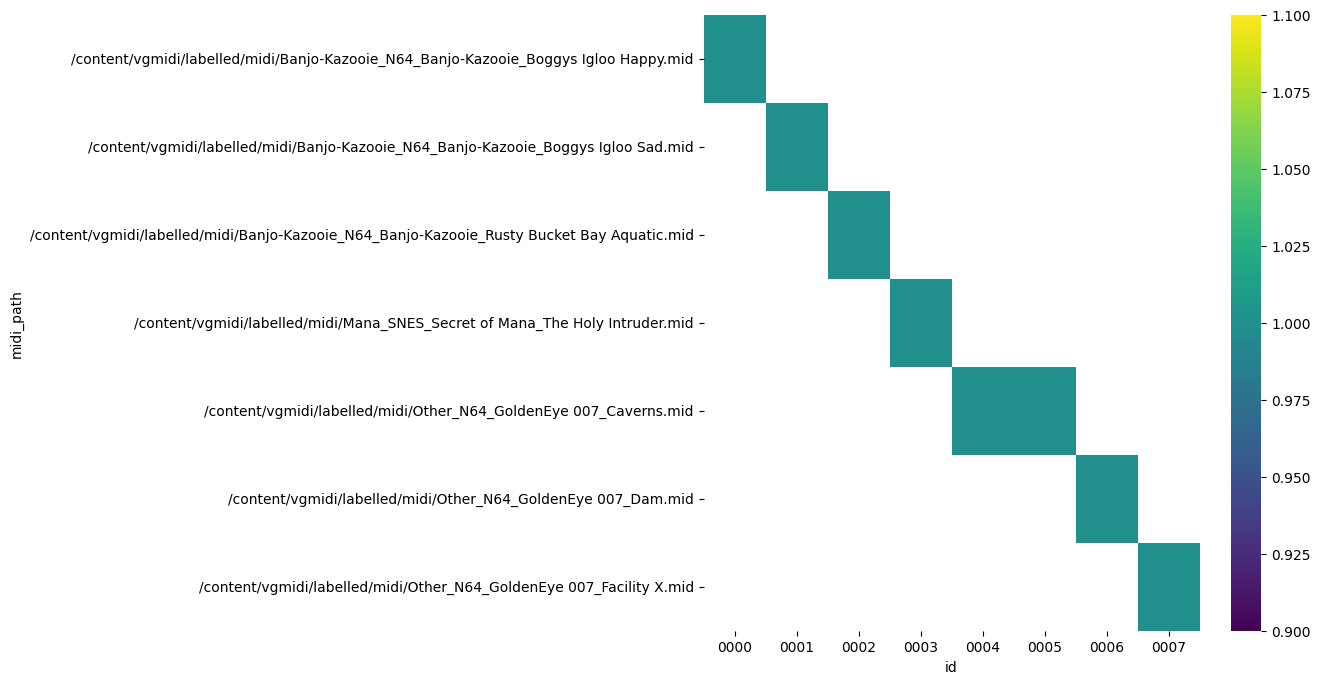

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['midi_path'].value_counts()
    for x_label, grp in _df_5.groupby('id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id')
_ = plt.ylabel('midi_path')

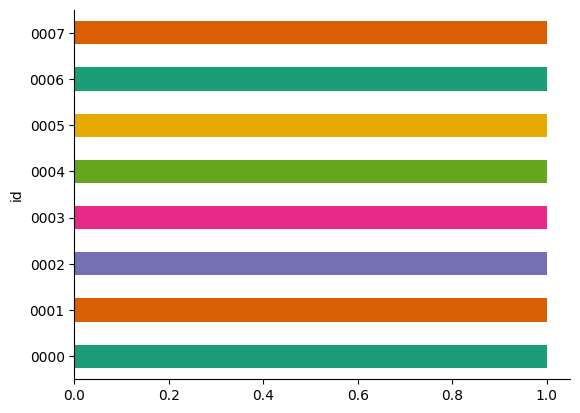

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
!apt-get -qq update
!pip -q install librosa==0.10.2.post1 soundfile pretty_midi rapidfuzz einops scikit-learn torch torchvision torchaudio

import os, random, json, glob, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display, soundfile as sf, pretty_midi as pm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from einops import rearrange

SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ROOT = "/content/data/vgmidi"
META = f"{ROOT}/meta.csv"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


样本总数: 105
可用音频: 0 | 可用MIDI: 105

类别分布：
label
Q1    41
Q4    40
Q2    18
Q3     6
Name: count, dtype: int64


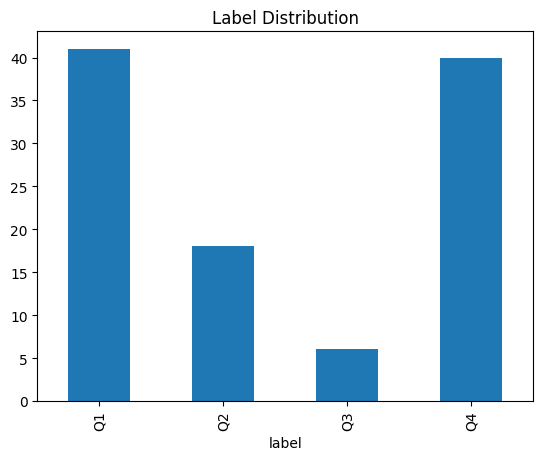

In [ ]:
meta = pd.read_csv(META)
print("样本总数:", len(meta))
meta["has_audio"] = meta["audio_path"].apply(lambda p: isinstance(p,str) and os.path.exists(p))
meta["has_midi"]  = meta["midi_path"].apply(lambda p: isinstance(p,str) and os.path.exists(p))
print("可用音频:", meta["has_audio"].sum(), "| 可用MIDI:", meta["has_midi"].sum())

print("\n类别分布：")
print(meta["label"].value_counts())

# 可视化类别柱状图
meta["label"].value_counts().sort_index().plot(kind="bar"); plt.title("Label Distribution"); plt.show()

# 若暂时只有MIDI（audio_path为空），先只跑MIDI分支；若两者都有，可跑双模态


In [ ]:
SR = 22050; HOP = 512

def extract_features_audio(path, sr=SR, hop_length=HOP, n_mels_list=(64,128)):
    y, sr = librosa.load(path, sr=sr, mono=True)
    mels = []
    for m in n_mels_list:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=m, hop_length=hop_length)
        mels.append(librosa.power_to_db(S + 1e-6))
    mel = np.concatenate(mels, axis=0)  # [sum(n_mels), T]
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram  = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    rms   = librosa.feature.rms(y=y, hop_length=hop_length)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

    T = min(mel.shape[1], tempogram.shape[1], rms.shape[1], chroma.shape[1], tonnetz.shape[1])
    feats = np.concatenate([mel[:, :T], tempogram[:, :T], rms[:, :T], chroma[:, :T], tonnetz[:, :T]], axis=0)
    # 归一化（每维零均值/单位方差）
    mu = feats.mean(axis=1, keepdims=True)
    std = feats.std(axis=1, keepdims=True) + 1e-6
    feats = (feats - mu) / std
    return feats.astype(np.float32)  # [F, T]


In [ ]:
def extract_features_midi(path):
    midi = pm.PrettyMIDI(path)
    # 音符集合
    notes = [n for inst in midi.instruments for n in inst.notes]
    if len(notes)==0:
        return np.zeros( (1,128), dtype=np.float32 )  # 极端兜底

    # 音高分布（Pitch Class）
    pc_hist = np.zeros(12, dtype=np.float32)
    for n in notes: pc_hist[n.pitch % 12] += (n.end - n.start)
    pc_hist = pc_hist / (pc_hist.sum()+1e-6)

    # 力度统计
    vels = np.array([n.velocity for n in notes], dtype=np.float32)
    vel_feat = np.array([vels.mean(), vels.std(), np.percentile(vels, [25,50,75]).mean()], dtype=np.float32)

    # 节奏：每秒音符密度 + 估计BPM
    duration = midi.get_end_time() - midi.get_onsets()[0] if len(midi.get_onsets()) else midi.get_end_time()
    density = len(notes)/(duration+1e-6)
    tempo = np.median([t[0] for t in midi.get_tempo_changes()[1]]) if len(midi.get_tempo_changes()[1])>0 else 120.0
    rhythm_feat = np.array([density, tempo], dtype=np.float32)

    # Tonnetz（从chromagram近似）
    sr = 22050
    audio = midi.fluidsynth(fs=sr)  # 直接软件合成一段短音频用于提取和声特征
    chroma = librosa.feature.chroma_cqt(y=audio, sr=sr)
    tonnetz = librosa.feature.tonnetz(chroma=chroma)
    ton_feat = tonnetz.mean(axis=1).astype(np.float32)

    feat = np.concatenate([pc_hist, vel_feat, rhythm_feat, ton_feat], axis=0)  # 12+3+2+6=23维
    return feat[None, :]  # [1, 23] 作为时间步为1的特征


In [ ]:
LABEL2ID = {"Q1":0,"Q2":1,"Q3":2,"Q4":3}

def stratified_split(df, ratios=(0.8,0.1,0.1)):
    parts = []
    for lab, g in df.groupby("label"):
        idx = list(g.index); random.shuffle(idx)
        n=len(idx); n_tr=int(n*ratios[0]); n_va=int(n*ratios[1])
        parts.append( ("train", df.loc[idx[:n_tr]]  ) )
        parts.append( ("val",   df.loc[idx[n_tr:n_tr+n_va]] ) )
        parts.append( ("test",  df.loc[idx[n_tr+n_va:]] ) )
    out = {k: pd.concat([p for t,p in parts if t==k], axis=0).reset_index(drop=True) for k in ["train","val","test"]}
    return out

splits = stratified_split(meta[meta["has_midi"] | meta["has_audio"]])

class VGMAudio(Dataset):
    def __init__(self, df): self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        A = extract_features_audio(r["audio_path"])
        return A, LABEL2ID[r["label"]]

class VGMIDI(Dataset):
    def __init__(self, df): self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        M = extract_features_midi(r["midi_path"])  # [1,23]
        return M, LABEL2ID[r["label"]]

def collate_audio(batch):
    T = min(x.shape[1] for x,_ in batch)
    X = np.stack([x[:, :T] for x,_ in batch], 0)
    y = torch.tensor([y for _,y in batch], dtype=torch.long)
    return torch.tensor(X), y

def collate_midi(batch):
    X = np.stack([x for x,_ in batch], 0)  # [B,1,23]
    y = torch.tensor([y for _,y in batch], dtype=torch.long)
    return torch.tensor(X), y


In [ ]:
class RRLA(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.h=heads; self.dk=dim//heads
        self.q=nn.Linear(dim, dim, bias=False)
        self.k=nn.Linear(dim, dim, bias=False)
        self.v=nn.Linear(dim, dim, bias=False)
        self.o=nn.Linear(dim, dim, bias=False)
        self.gate=nn.Parameter(torch.zeros(heads))
        self.drop=nn.Dropout(dropout)
    @staticmethod
    def rope(x):  # [B,T,D]
        B,T,D=x.shape; d=D//2
        freqs=torch.arange(d, device=x.device).float()
        freqs=1.0/(10000**(freqs/d))
        pos=torch.arange(T, device=x.device).float()[:,None]
        ang=pos*freqs[None,:]
        cos,sin=ang.cos(), ang.sin()
        x1,x2=x[...,:d], x[...,d:]
        return torch.cat([x1*cos-x2*sin, x1*sin+x2*cos], dim=-1)
    @staticmethod
    def phi(x): return F.elu(x)+1.0
    def forward(self, x):  # x:[B,T,D]
        B,T,D=x.shape; h=self.h; dk=self.dk
        q=self.q(x).view(B,T,h,dk).transpose(1,2); k=self.k(x).view(B,T,h,dk).transpose(1,2); v=self.v(x).view(B,T,h,dk).transpose(1,2)
        q=self.rope(q.reshape(B*h,T,dk)).reshape(B,h,T,dk); k=self.rope(k.reshape(B*h,T,dk)).reshape(B,h,T,dk)
        qf,kf=self.phi(q), self.phi(k)
        kv=torch.einsum('bhtd,bhte->bhde', kf, v)
        z=1.0/(torch.einsum('bhtd,bhd->bht', qf, kf.sum(dim=2))+1e-6)
        out=torch.einsum('bhtd,bhde->bhte', qf, kv) * z.unsqueeze(-1)
        gate=torch.sigmoid(self.gate).view(1,h,1,1)
        out=(out*gate).transpose(1,2).reshape(B,T,D)
        return self.o(self.drop(out))

class ConformerLite(nn.Module):
    def __init__(self, dim, heads=4, expansion=2, kernel=7, drop=0.1):
        super().__init__()
        self.ff1=nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim,expansion*dim), nn.GLU(), nn.Linear(expansion*dim//2, dim))
        self.att=nn.Sequential(nn.LayerNorm(dim), RRLA(dim, heads, drop))
        self.dw =nn.Sequential(nn.LayerNorm(dim))
        self.dwconv=nn.Sequential(nn.Conv1d(dim,dim,kernel,padding=kernel//2,groups=dim), nn.SiLU(), nn.Conv1d(dim,dim,1))
        self.ff2=nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim,expansion*dim), nn.GLU(), nn.Linear(expansion*dim//2, dim))
        self.drop=nn.Dropout(drop)
    def forward(self,x):  # [B,T,D]
        x=x+self.drop(self.ff1(x))
        x=x+self.drop(self.att(x))
        y=self.dw(x); y=self.dwconv(rearrange(y,'b t d->b d t')); y=rearrange(y,'b d t->b t d')
        x=x+self.drop(y)
        x=x+self.drop(self.ff2(x))
        return x

class ATEM_Audio(nn.Module):
    def __init__(self, in_feats, dim=256, depth=4, heads=4, classes=4):
        super().__init__()
        self.proj=nn.Conv1d(in_feats, dim, 1)
        self.blocks=nn.ModuleList([ConformerLite(dim, heads=heads) for _ in range(depth)])
        self.norm=nn.LayerNorm(dim)
        self.pool=nn.AdaptiveAvgPool1d(1)
        self.head=nn.Linear(dim, classes)
    def forward(self, A):            # A:[B,F,T]
        x=self.proj(A).transpose(1,2)  # [B,T,D]
        for blk in self.blocks: x=blk(x)
        x=self.norm(x)
        z=self.pool(x.transpose(1,2)).squeeze(-1)
        return self.head(z)


In [ ]:
class MIDI_MLP(nn.Module):
    def __init__(self, in_feats=23, hid=128, classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_feats),
            nn.Linear(in_feats, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, classes)
        )
    def forward(self, M):   # M:[B,1,23]
        x = M.squeeze(1)    # [B,23]
        return self.net(x)


In [ ]:
class GatedFusion(nn.Module):
    def __init__(self, d_a, d_m, d_out=256):
        super().__init__()
        self.wa = nn.Linear(d_a, d_out); self.wm = nn.Linear(d_m, d_out)
        self.g = nn.Linear(d_a+d_m, d_out)
    def forward(self, za, zm):  # za,zm:[B,D]
        h = torch.tanh(self.wa(za) + self.wm(zm))
        gate = torch.sigmoid(self.g(torch.cat([za, zm], dim=-1)))
        return h * gate

class ATEM_Bimodal(nn.Module):
    def __init__(self, f_audio, f_midi, classes=4):
        super().__init__()
        self.audio = ATEM_Audio(in_feats=f_audio, dim=192, depth=3, heads=4, classes=classes)
        self.mlp   = MIDI_MLP(in_feats=f_midi, hid=128, classes=classes)
        # 取分类头前一层的特征：这边做一个小改写
        self.audio.head = nn.Identity()
        self.mlp.net[-1]   = nn.Identity()
        self.fuse = GatedFusion(192, 128, 256)
        self.cls  = nn.Linear(256, classes)
    def forward(self, A, M):
        za = self.audio(A)  # [B,192]
        zm = self.mlp(M)    # [B,128]
        z  = self.fuse(za, zm)
        return self.cls(z)


In [ ]:
import os, pandas as pd

META = "/content/data/vgmidi/meta.csv"

meta = pd.read_csv(META)

def midi_ok(p: str) -> bool:
    return isinstance(p, str) and p.lower().endswith((".mid", ".midi")) \
           and os.path.exists(p) and os.path.getsize(p) > 0

df_midi = meta[meta["midi_path"].apply(midi_ok)].copy()
print("可用 MIDI 样本数：", len(df_midi))
print(df_midi[["midi_path","label"]].head(3))

assert len(df_midi) > 0, "没有可用 MIDI。请先检查 meta.csv 的 midi_path 是否存在于磁盘。"


可用 MIDI 样本数： 105
                                           midi_path label
0  /content/vgmidi/labelled/midi/Banjo-Kazooie_N6...    Q4
1  /content/vgmidi/labelled/midi/Banjo-Kazooie_N6...    Q1
2  /content/vgmidi/labelled/midi/Banjo-Kazooie_N6...    Q4


In [ ]:
!pip -q install pretty_midi librosa==0.10.2.post1 soundfile

import numpy as np, librosa, pretty_midi as pm

def extract_features_midi(path):
    """返回 shape=[1, 23] 的稳定特征；任何异常都返回全零，避免 __getitem__ 报错。"""
    # 兜底
    Z = np.zeros((1, 23), dtype=np.float32)
    try:
        midi = pm.PrettyMIDI(path)
    except Exception as e:
        print("[warn] 解析 MIDI 失败：", path, "->", e)
        return Z

    # 采集音符
    notes = [n for inst in midi.instruments for n in inst.notes]
    if len(notes) == 0:
        return Z

    # 1) Pitch-class 时长直方图 12
    pc = np.zeros(12, dtype=np.float32)
    for n in notes:
        pc[n.pitch % 12] += (n.end - n.start)
    pc = pc / (pc.sum() + 1e-6)

    # 2) 力度统计 3（均值/方差/四分位均值）
    vels = np.array([n.velocity for n in notes], dtype=np.float32)
    vel_feat = np.array([vels.mean(), vels.std(), np.percentile(vels, [25,50,75]).mean()], dtype=np.float32)

    # 3) 节奏 2（密度 + 估计BPM）
    try:
        onsets = midi.get_onsets()
        start  = onsets[0] if len(onsets) else 0.0
        duration = max(midi.get_end_time() - start, 1e-3)
    except Exception:
        duration = max(midi.get_end_time(), 1e-3)
    density = len(notes) / duration
    try:
        tempi = midi.get_tempo_changes()[1]
        tempo = float(np.median(tempi)) if len(tempi) else 120.0
    except Exception:
        tempo = 120.0
    rhythm_feat = np.array([density, tempo], dtype=np.float32)

    # 4) Tonnetz 6（若缺渲染依赖则置零）
    ton_feat = np.zeros(6, dtype=np.float32)
    try:
        # pretty_midi.fluidsynth 需要 pyfluidsynth；若未安装会抛错，自动走 except
        sr = 22050
        audio = midi.fluidsynth(fs=sr)  # 若失败会进入 except
        chroma = librosa.feature.chroma_cqt(y=audio.astype(np.float32), sr=sr)
        tonnetz = librosa.feature.tonnetz(chroma=chroma)
        ton_feat = tonnetz.mean(axis=1).astype(np.float32)
    except Exception:
        pass  # 保持 ton_feat 为 0 向量

    feat = np.concatenate([pc, vel_feat, rhythm_feat, ton_feat], axis=0)  # 12+3+2+6=23
    return feat[None, :]  # [1,23]


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch, numpy as np

LABEL2ID = {"Q1":0,"Q2":1,"Q3":2,"Q4":3}

# 分层切分（train/val/test=8/1/1）
import random
def stratified_split(df, ratios=(0.8,0.1,0.1), seed=2025):
    random.seed(seed)
    parts = []
    for lab, g in df.groupby("label"):
        idx = list(g.index); random.shuffle(idx)
        n=len(idx); n_tr=int(n*ratios[0]); n_va=int(n*ratios[1])
        parts += [("train", df.loc[idx[:n_tr]]),
                  ("val",   df.loc[idx[n_tr:n_tr+n_va]]),
                  ("test",  df.loc[idx[n_tr+n_va:]])]
    return {k: pd.concat([p for t,p in parts if t==k]).reset_index(drop=True) for k in ["train","val","test"]}

spl = stratified_split(df_midi)

class VGMIDI(Dataset):
    def __init__(self, df): self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = extract_features_midi(r["midi_path"])  # [1,23] 或 兜底零
        y = LABEL2ID[str(r["label"])]
        return x.astype(np.float32), y

def collate_midi(batch):
    feats, labels = [], []
    for x,y in batch:
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]   # [23] -> [1,23]
        feats.append(x)
        labels.append(y)
    X = np.stack(feats, 0).astype(np.float32)  # [B,1,23]
    y = torch.tensor(labels, dtype=torch.long)
    return torch.tensor(X), y

tr_m, va_m, te_m = VGMIDI(spl["train"]), VGMIDI(spl["val"]), VGMIDI(spl["test"])
print("len:", len(tr_m), len(va_m), len(te_m))
assert len(tr_m) > 0 and len(va_m) > 0, "切分后为空，请检查标签分布或样本数。"

lm = DataLoader(tr_m, batch_size=16, shuffle=True,  collate_fn=collate_midi)
vm = DataLoader(va_m, batch_size=16, shuffle=False, collate_fn=collate_midi)
tm = DataLoader(te_m, batch_size=16, shuffle=False, collate_fn=collate_midi)

# 用样本确定维度（不会越界）
sample_M, _ = tr_m[0]
f_midi = sample_M.shape[-1]
print("f_midi =", f_midi, "batch shape:", next(iter(lm))[0].shape)


len: 82 9 14
f_midi = 23 batch shape: torch.Size([16, 1, 23])


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/tmp/ipython-input-1083117336.py:35: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  losses.append(float(loss))
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep01] tr_acc=0.220 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep02] tr_acc=0.317 va_acc=0.556 va_f1=0.356


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep03] tr_acc=0.341 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep04] tr_acc=0.427 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep05] tr_acc=0.341 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep06] tr_acc=0.402 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[Ep07] tr_acc=0.390 va_acc=0.444 va_f1=0.205


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWar

              precision    recall  f1-score   support

          Q1       0.33      0.20      0.25         5
          Q2       0.00      0.00      0.00         3
          Q3       0.00      0.00      0.00         2
          Q4       0.36      1.00      0.53         4

    accuracy                           0.36        14
   macro avg       0.17      0.30      0.20        14
weighted avg       0.22      0.36      0.24        14



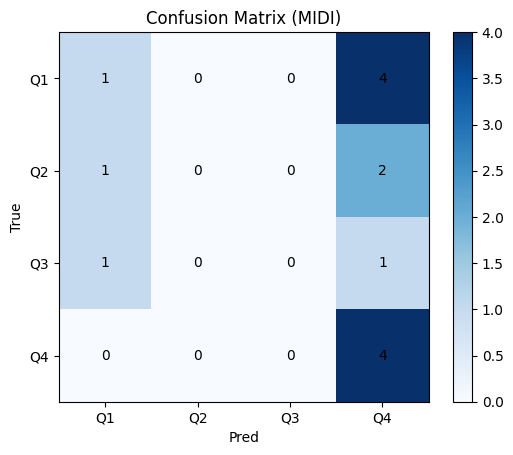

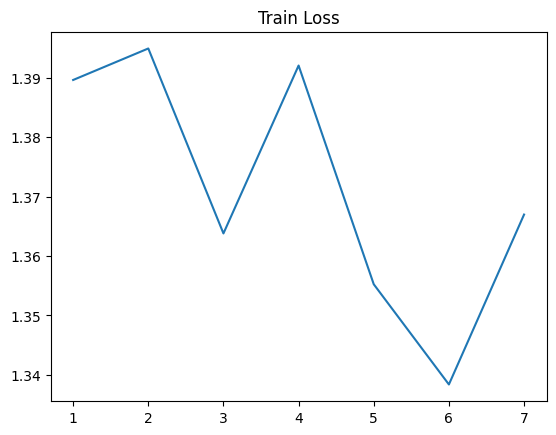

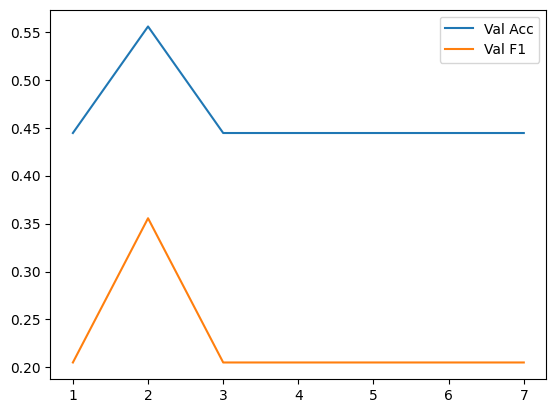

In [ ]:
import torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class MIDI_MLP(nn.Module):
    def __init__(self, in_feats=23, hid=128, classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_feats),
            nn.Linear(in_feats, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, classes)
        )
    def forward(self, M):  # [B,1,23]
        return self.net(M.squeeze(1))

def class_weights(df):
    vc = df["label"].map(LABEL2ID).value_counts().reindex([0,1,2,3], fill_value=1)
    w = vc.max()/vc.values
    return torch.tensor(w, dtype=torch.float32).to(DEVICE)

def run_epoch(model, loader, opt=None, cw=None):
    model.train() if opt else model.eval()
    losses, y_true, y_pred = [], [], []
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss = F.cross_entropy(logits, y, weight=cw)
        if opt:
            opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        losses.append(float(loss))
        y_true += y.tolist(); y_pred += logits.argmax(-1).tolist()
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return np.mean(losses), acc, f1

model = MIDI_MLP(in_feats=f_midi, hid=128, classes=4).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)
cw    = class_weights(df_midi)

best_f1, bad, patience = -1, 0, 5
hist = []
for ep in range(1, 80):
    tr = run_epoch(model, lm, opt, cw)
    va = run_epoch(model, vm, None, cw)
    hist.append((ep,)+tr+va)
    print(f"[Ep{ep:02d}] tr_acc={tr[1]:.3f} va_acc={va[1]:.3f} va_f1={va[2]:.3f}")
    if va[2] > best_f1: best_f1 = va[2]; torch.save(model.state_dict(), "/content/data/vgmidi/best_midi.pt"); bad=0
    else: bad += 1
    if bad >= patience: break

# 测试集评估
model.load_state_dict(torch.load("/content/data/vgmidi/best_midi.pt"))
y_true, y_pred = [], []
with torch.no_grad():
    for X,y in tm:
        X = X.to(DEVICE)
        logits = model(X)
        y_true += y.tolist()
        y_pred += logits.argmax(-1).cpu().tolist()

print(classification_report(y_true, y_pred, target_names=["Q1","Q2","Q3","Q4"]))

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix (MIDI)"); plt.colorbar()
plt.xticks(range(4),["Q1","Q2","Q3","Q4"]); plt.yticks(range(4),["Q1","Q2","Q3","Q4"])
for i in range(4):
    for j in range(4):
        plt.text(j,i,cm[i,j],ha='center',va='center',color='black')
plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

# 训练曲线
if hist:
    ep, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1 = zip(*hist)
    plt.plot(ep, tr_loss); plt.title("Train Loss"); plt.show()
    plt.plot(ep, va_acc, label="Val Acc"); plt.plot(ep, va_f1, label="Val F1"); plt.legend(); plt.show()


In [ ]:
for name, df in [("train", spl["train"]), ("val", spl["val"]), ("test", spl["test"])]:
    print(name, df["label"].value_counts())


train label
Q1    32
Q4    32
Q2    14
Q3     4
Name: count, dtype: int64
val label
Q1    4
Q4    4
Q2    1
Name: count, dtype: int64
test label
Q1    5
Q4    4
Q2    3
Q3    2
Name: count, dtype: int64


In [ ]:
import numpy as np
preds = np.array(y_pred)  # 你测试阶段得到的预测列表
print("pred distribution:", {i: (preds==i).mean() for i in range(4)})


pred distribution: {0: np.float64(0.21428571428571427), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.7857142857142857)}


# emopia

In [ ]:
# ---------- 读取标签（优先 emopia_idx.npz → 再 idx2fn → 最后才考虑 .npz 内 y） ----------

import numpy as np, json, re, os

LABEL2ID = {"Q1":0,"Q2":1,"Q3":2,"Q4":3}

def first_key(d, cand):
    for k in cand:
        if k in d: return k
    return None

N = x.shape[0]  # 之前已经读取了 x

labels = None

# 1) 优先：从 emopia_idx.npz 读取四象限索引
if os.path.exists(CONFIG["PATH_IDX"]):
    IDX = np.load(CONFIG["PATH_IDX"], allow_pickle=True)
    lab = np.array([""]*N, dtype="<U2")
    for i,key in enumerate(["cls_1_idx","cls_2_idx","cls_3_idx","cls_4_idx"], start=1):
        if key in IDX:
            idxs = np.array(IDX[key]).astype(int).ravel()
            idxs = idxs[(idxs>=0) & (idxs<N)]
            lab[idxs] = f"Q{i}"
    if (lab != "").any():
        # 若存在未覆盖的样本，后续用 idx2fn 补齐
        labels = lab

# 2) 次优：从 emopia_fn2idx_map.json 的 idx2fn 前缀解析
if (labels is None) or (labels == "").any():
    if os.path.exists(CONFIG["PATH_MAP"]):
        with open(CONFIG["PATH_MAP"], "r") as f:
            mapping = json.load(f)
        assert "idx2fn" in mapping, "idx2fn 未在 JSON 中找到"
        idx2fn = mapping["idx2fn"]
        fill = []
        for i in range(N):
            if (labels is not None) and labels[i] != "":
                fill.append(labels[i]); continue
            name = str(idx2fn.get(str(i), ""))
            m = re.match(r"(Q[1-4])_", name, flags=re.I)
            if not m:
                fill.append("")  # 暂空，留给下一步
            else:
                fill.append(m.group(1).upper())
        labels = np.array(fill, dtype="<U2")

# 3) 最后尝试：只有当 y 真的是标签时才使用 .npz 内的 y（我们会自动判别）
if (labels == "").any():
    k_y = first_key(DATA, ["y","label","labels","Y"])
    used_npz_y = False
    if k_y is not None:
        y_raw = np.array(DATA[k_y])
        # 仅当 y 是 (N,), (N,1) 或 (N,4) one-hot 时才当标签；否则忽略
        if (y_raw.ndim == 1 and y_raw.shape[0] == N) or \
           (y_raw.ndim == 2 and y_raw.shape[0] == N and y_raw.shape[1] in (1,4)):
            used_npz_y = True
            if y_raw.ndim == 2 and y_raw.shape[1] == 1:
                y_vec = y_raw[:,0]
            elif y_raw.ndim == 2 and y_raw.shape[1] == 4:
                y_vec = y_raw.argmax(axis=1)
            else:
                y_vec = y_raw
            y_int = np.rint(y_vec).astype(int)
            if y_int.min()==0 and y_int.max()==3: y_int = y_int + 1
            y_int = np.clip(y_int, 1, 4)
            labels_fallback = np.array([f"Q{i}" for i in y_int], dtype="<U2")
            # 仅填充之前的空位
            mask_empty = (labels == "")
            labels[mask_empty] = labels_fallback[mask_empty]
        else:
            print(f"[INFO] 检测到 '{k_y}' 形状为 {y_raw.shape}，看起来是序列张量，已忽略。")

# 4) 最终校验
assert (labels != "").all(), "仍有样本无法确定标签：请检查 emopia_idx.npz / emopia_fn2idx_map.json 是否完整。"
print("Label counts:", {k:int(v) for k,v in zip(*np.unique(labels, return_counts=True))})

y_id = np.array([LABEL2ID[l] for l in labels], dtype=np.int64)


Label counts: {np.str_('Q1'): 239, np.str_('Q2'): 262, np.str_('Q3'): 244, np.str_('Q4'): 307}


In [ ]:
# ============================================================
# EMOPIA (.npz) 最小可运行：Dataset/Loader + MLP / 序列注意力
# 支持 Q1~Q4 或 Q1~Q9；NUM_CLASSES 配置可切换；含均衡采样与评估可视化
# ============================================================

# 0) 依赖
!pip -q install torch torchvision torchaudio einops scikit-learn

import os, re, json, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Any

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from einops import rearrange

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ----------------------------
# 1) 配置
# ----------------------------
CONFIG = {
    "PATH_DATA": "/content/emopia_data.npz",        # 包含 x / seq_len / (可选) y / mask
    "PATH_IDX":  "/content/emopia_idx.npz",         # 可选
    "PATH_MAP":  "/content/emopia_fn2idx_map.json", # 可选：idx2fn 中若带 Q1_ 前缀可用

    "MODEL": "mlp",        # "mlp" 或 "seq"
    "NUM_CLASSES": 4,      # 4 或 9
    "FOUR_CLASS_MODE": "filter",  # 当 NUM_CLASSES=4 且出现 Q5~Q9 时的处理："filter"=过滤（推荐）

    "EPOCHS": 30 if torch.cuda.is_available() else 10,
    "BATCH_MLP": 32,
    "BATCH_SEQ": 12,
    "LR": 2e-3,
    "WEIGHT_DECAY": 1e-2,
    "PATIENCE": 6,

    "SPLIT": (0.8, 0.1, 0.1),
    "USE_BALANCED_SAMPLER": True,

    "MAX_LEN": 1024,
    "EMB_DIM": 192,    # 偶数
    "DEPTH": 3,
    "HEADS": 4,
    "BOW_MAX_BINS": 128
}



In [ ]:
# ----------------------------
# 2) 读取数据 & 解析标签（鲁棒）
# ----------------------------
def try_read_npz(path):
    assert os.path.exists(path), f"文件不存在: {path}"
    return np.load(path, allow_pickle=True)

DATA = try_read_npz(CONFIG["PATH_DATA"])

def first_key(d: Dict, candidates: List[str]):
    for k in candidates:
        if k in d: return k
    return None

k_x   = first_key(DATA, ["x", "X", "data"])
k_len = first_key(DATA, ["seq_len", "lengths", "L", "len"])
x = DATA[k_x]
seq_len = DATA[k_len] if k_len is not None else np.full((len(x),), x.shape[1], dtype=np.int32)

# 标签解析
def to_Q_label(v: Any) -> str:
    if isinstance(v, (str, bytes)):
        s = v.decode() if isinstance(v, bytes) else v
        m = re.match(r"\s*Q\s*([1-9])", s.strip(), flags=re.I)
        if m: return f"Q{int(m.group(1))}"
        try:
            iv = int(float(s))
            if iv in range(1,10): return f"Q{iv}"
            if iv in range(0,9):  return f"Q{iv+1}"
        except Exception:
            pass
        raise ValueError(f"无法解析标签字符串: {s}")

    arr = np.asarray(v)
    if arr.size == 1:
        iv = int(arr.reshape(-1)[0])
        if iv in range(1,10): return f"Q{iv}"
        if iv in range(0,9):  return f"Q{iv+1}"
        iv = max(0, min(8, iv)); return f"Q{iv+1}"
    idx = int(np.argmax(arr))   # 兼容 one-hot/prob
    return f"Q{idx+1}"

labels = None
k_y = first_key(DATA, ["y", "Y", "label", "labels"])
if k_y is not None:
    y_raw = DATA[k_y]
    labels = np.array([to_Q_label(v) for v in y_raw], dtype='<U3')
elif os.path.exists(CONFIG["PATH_MAP"]):
    with open(CONFIG["PATH_MAP"], "r") as f:
        mapping = json.load(f)
    assert "idx2fn" in mapping, "idx2fn 未在 JSON 中找到"
    idx2fn = mapping["idx2fn"]
    labels = []
    for i in range(len(x)):
        name = idx2fn.get(str(i), "")
        m = re.match(r"(Q[1-9])_", name)
        assert m, f"无法从 {name} 解析 Qk_ 前缀"
        labels.append(m.group(1))
    labels = np.array(labels, dtype='<U3')
else:
    raise RuntimeError("无法确定标签：需要 y 或 idx2fn(Qk_*)")

# 标准化形状：x => [N,T,C]
if x.ndim == 2:
    x = x[:, :, None]
N, T, C = x.shape
print(f"[INFO] RAW x shape = {x.shape}, seq_len range = [{seq_len.min()}..{seq_len.max()}], channels = {C}")
print("RAW Label counts:\n", pd.Series(labels).value_counts().sort_index())



[INFO] RAW x shape = (1052, 1024, 8), seq_len range = [99..1019], channels = 8
RAW Label counts:
 Q10    681
Q11     16
Q12     18
Q13     22
Q14     13
      ... 
Q94      1
Q95      2
Q96      2
Q97      3
Q98      4
Name: count, Length: 82, dtype: int64


In [ ]:
def map_9Q_to_4Q(labels_9q, mode="strict", check_counts=True):
    """
    labels_9q: 可迭代的 'Q1'..'Q9' 字符串（大小写/空格均可，内部会规范化）
    mode: 'strict' -> 仅角点，含0的格子全部丢弃
          'soft'   -> 采用固定折叠(见上面的方案B)，仅丢弃中心Q5
    return:
        labels_4q: 映射后的 'Q1'..'Q4' 列表
        keep_mask: 布尔数组（True表示保留）
    """
    import re, numpy as np, pandas as pd

    # 规范化
    def canon(s):
        s = str(s).strip().upper()
        m = re.search(r'Q\s*([1-9])', s)
        if not m:
            raise ValueError(f"未知标签: {s}")
        k = max(1, min(9, int(m.group(1))))
        return f"Q{k}"

    L = np.array([canon(s) for s in labels_9q], dtype=object)

    if mode == "strict":
        map_dict = {
            "Q1":"Q2",  # (V-,A+) -> Q2
            "Q3":"Q1",  # (V+,A+) -> Q1
            "Q7":"Q3",  # (V-,A-) -> Q3
            "Q9":"Q4",  # (V+,A-) -> Q4
        }
        keep = np.isin(L, list(map_dict.keys()))
        out = np.array([map_dict[x] if x in map_dict else None for x in L], dtype=object)
        out = out[keep]

    elif mode == "soft":
        map_dict = {
            "Q1":"Q2",  # (V-,A+) -> Q2
            "Q3":"Q1",  # (V+,A+) -> Q1
            "Q7":"Q3",  # (V-,A-) -> Q3
            "Q9":"Q4",  # (V+,A-) -> Q4
            "Q4":"Q3",  # (V-,A0) -> Q3  (把A0视作偏低)
            "Q6":"Q4",  # (V+,A0) -> Q4
            "Q2":"Q1",  # (V0,A+) -> Q1  (把V0视作偏正)
            "Q8":"Q4",  # (V0,A-) -> Q4
            # "Q5": 丢弃
        }
        keep = np.array([x in map_dict for x in L], dtype=bool)
        out  = np.array([map_dict[x] for x in L[keep]], dtype=object)

    else:
        raise ValueError("mode 必须是 'strict' 或 'soft'")

    if check_counts:
        import pandas as pd
        print("9Q 计数：\n", pd.Series(L).value_counts().sort_index())
        print("保留比例：", keep.sum(), "/", len(L))
        print("4Q 计数：\n", pd.Series(out).value_counts().sort_index())

    return out.tolist(), keep

# —— 示例用法（把 labels_9q 换成你当前的标签数组）——
# labels_4q, keep_mask = map_9Q_to_4Q(labels_9q=labels, mode="strict")  # 或 mode="soft"
# x_4q, seq_len_4q = x[keep_mask], seq_len[keep_mask]
# 然后用 labels_4q 继续做分层划分与训练。


In [ ]:
# ----------------------------
# 4) 分层划分 & 统计 vocab
# ----------------------------
def stratified_indices(y, ratios=(0.8,0.1,0.1), seed=SEED):
    rng = np.random.RandomState(seed)
    idx = np.arange(len(y))
    splits = {"train": [], "val": [], "test": []}
    for cls in np.unique(y):
        cls_idx = idx[y==cls]
        rng.shuffle(cls_idx)
        n = len(cls_idx); n_tr = int(n*ratios[0]); n_va = int(n*ratios[1])
        splits["train"].extend(cls_idx[:n_tr])
        splits["val"].extend(cls_idx[n_tr:n_tr+n_va])
        splits["test"].extend(cls_idx[n_tr+n_va:])
    for k in splits: splits[k] = np.array(splits[k], dtype=np.int64)
    return splits

SPL = stratified_indices(y_id, CONFIG["SPLIT"])
print({k: len(v) for k,v in SPL.items()})

def channel_vocabs(x_tr, bow_cap=CONFIG["BOW_MAX_BINS"]):
    vmax = x_tr.max(axis=(0,1))  # 每通道最大值
    voc = np.clip(vmax + 1, 2, bow_cap)  # 至少 2
    return voc.astype(np.int64)

vocabs = channel_vocabs(x[SPL["train"]], CONFIG["BOW_MAX_BINS"])
print("Per-channel vocab (cap):", vocabs.tolist())



{'train': 840, 'val': 103, 'test': 109}
Per-channel vocab (cap): [56, 128, 18, 4, 87, 18, 42, 5]


In [ ]:
# ----------------------------
# 5) Dataset / Collate
# ----------------------------
class EMOPIASeq(Dataset):
    def __init__(self, x, L, y, idx, max_len=1024):
        self.x = x[idx]; self.L = L[idx]; self.y = y[idx]; self.max_len = max_len
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        Xi, Li = self.x[i], int(self.L[i])
        Li = max(1, min(Li, Xi.shape[0], self.max_len))
        Xi = Xi[:Li]                    # [Li, C]
        return Xi.astype(np.int64), int(self.y[i]), Li

def collate_seq(batch):
    Ls = [Li for _,_,Li in batch]
    Lmax = max(Ls)
    C = batch[0][0].shape[1]
    Xpad = np.zeros((len(batch), Lmax, C), dtype=np.int64)
    M = np.zeros((len(batch), Lmax), dtype=np.bool_)  # mask: True for valid
    y = []
    for i,(Xi,yi,Li) in enumerate(batch):
        Xpad[i,:Li] = Xi
        M[i,:Li] = True
        y.append(yi)
    return torch.from_numpy(Xpad), torch.tensor(y, dtype=torch.long), torch.from_numpy(M)

class EMOPIABoW(Dataset):
    def __init__(self, x, L, y, idx, vocabs):
        self.x = x[idx]; self.L = L[idx]; self.y = y[idx]
        self.vocabs = vocabs
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        Xi, Li = self.x[i], int(self.L[i])
        Li = max(1, min(Li, Xi.shape[0]))
        Xi = Xi[:Li]  # [Li, C]
        feats = []
        for c in range(Xi.shape[1]):
            vmax = int(self.vocabs[c])
            v = Xi[:,c]
            v = np.clip(v, 0, vmax-1)
            hist = np.bincount(v, minlength=vmax).astype(np.float32)
            feats.append(hist)
        f = np.concatenate(feats, axis=0).astype(np.float32)
        mu, sd = f.mean(), f.std() + 1e-6
        f = (f - mu) / sd
        return f[None,:], int(self.y[i])   # [1,D], y

def collate_bow(batch):
    X = np.stack([b[0] for b in batch], 0).astype(np.float32)   # [B,1,D]
    y = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return torch.from_numpy(X), y

# 构建 DataLoader（含可选均衡采样）
if CONFIG["MODEL"] == "seq":
    tr_ds = EMOPIASeq(x, seq_len, y_id, SPL["train"], max_len=CONFIG["MAX_LEN"])
    va_ds = EMOPIASeq(x, seq_len, y_id, SPL["val"],   max_len=CONFIG["MAX_LEN"])
    te_ds = EMOPIASeq(x, seq_len, y_id, SPL["test"],  max_len=CONFIG["MAX_LEN"])
    if CONFIG["USE_BALANCED_SAMPLER"]:
        labs = [tr_ds[i][1] for i in range(len(tr_ds))]
        binc = np.bincount(labs, minlength=len(classes))
        w = 1.0 / (binc[labs] + 1e-9)
        sampler = WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double), num_samples=len(labs), replacement=True)
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_SEQ"], sampler=sampler, collate_fn=collate_seq)
    else:
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=True, collate_fn=collate_seq)
    val_loader = DataLoader(va_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=False, collate_fn=collate_seq)
    test_loader= DataLoader(te_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=False, collate_fn=collate_seq)
else:
    tr_ds = EMOPIABoW(x, seq_len, y_id, SPL["train"], vocabs)
    va_ds = EMOPIABoW(x, seq_len, y_id, SPL["val"],   vocabs)
    te_ds = EMOPIABoW(x, seq_len, y_id, SPL["test"],  vocabs)
    if CONFIG["USE_BALANCED_SAMPLER"]:
        labs = [tr_ds[i][1] for i in range(len(tr_ds))]
        binc = np.bincount(labs, minlength=len(classes))
        w = 1.0 / (binc[labs] + 1e-9)
        sampler = WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double), num_samples=len(labs), replacement=True)
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_MLP"], sampler=sampler, collate_fn=collate_bow)
    else:
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=True, collate_fn=collate_bow)
    val_loader = DataLoader(va_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=False, collate_fn=collate_bow)
    test_loader= DataLoader(te_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=False, collate_fn=collate_bow)

# ----------------------------
# 6) 模型（MLP / 序列注意力）
# ----------------------------
class BoW_MLP(nn.Module):
    def __init__(self, in_feats, hid=256, classes=4, drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_feats),
            nn.Linear(in_feats, hid), nn.GELU(), nn.Dropout(drop),
            nn.Linear(hid, hid), nn.GELU(), nn.Dropout(drop),
            nn.Linear(hid, classes)
        )
    def forward(self, X):  # X: [B,1,D]
        return self.net(X.squeeze(1))

class RRLA(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        assert dim % heads == 0
        self.h=heads; self.dk=dim//heads
        self.q=nn.Linear(dim, dim, bias=False); self.k=nn.Linear(dim, dim, bias=False); self.v=nn.Linear(dim, dim, bias=False)
        self.o=nn.Linear(dim, dim, bias=False)
        self.gate=nn.Parameter(torch.zeros(heads))
        self.drop=nn.Dropout(dropout)
    @staticmethod
    def rope(x):  # [B,T,D]
        B,T,D=x.shape; d=D//2
        freqs=torch.arange(d, device=x.device).float()
        freqs=1.0/(10000**(freqs/d))
        pos=torch.arange(T, device=x.device).float()[:,None]
        ang=pos*freqs[None,:]; cos,sin=ang.cos(), ang.sin()
        x1,x2=x[...,:d], x[...,d:]
        return torch.cat([x1*cos-x2*sin, x1*sin+x2*cos], dim=-1)
    @staticmethod
    def phi(x): return F.elu(x)+1.0
    def forward(self, x, mask=None):  # x:[B,T,D], mask:[B,T]
        B,T,D=x.shape; h=self.h; dk=self.dk
        q=self.q(x).view(B,T,h,dk).transpose(1,2); k=self.k(x).view(B,T,h,dk).transpose(1,2); v=self.v(x).view(B,T,h,dk).transpose(1,2)
        q=self.rope(q.reshape(B*h,T,dk)).reshape(B,h,T,dk); k=self.rope(k.reshape(B*h,T,dk)).reshape(B,h,T,dk)
        qf,kf=self.phi(q), self.phi(k)
        kv=torch.einsum('bhtd,bhte->bhde', kf, v)
        z=1.0/(torch.einsum('bhtd,bhd->bht', qf, kf.sum(dim=2))+1e-6)
        out=torch.einsum('bhtd,bhde->bhte', qf, kv) * z.unsqueeze(-1)
        gate=torch.sigmoid(self.gate).view(1,h,1,1)
        out=(out*gate).transpose(1,2).contiguous().view(B,T,D)
        return self.o(self.drop(out))

class ConformerLite(nn.Module):
    def __init__(self, dim, heads=4, expansion=2, kernel=7, drop=0.1):
        super().__init__()
        self.ff1=nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim,expansion*dim), nn.GLU(), nn.Linear(expansion*dim//2, dim))
        self.att=nn.Sequential(nn.LayerNorm(dim), RRLA(dim, heads, drop))
        self.dw =nn.Sequential(nn.LayerNorm(dim))
        self.dwconv=nn.Sequential(nn.Conv1d(dim,dim,kernel,padding=kernel//2,groups=dim), nn.SiLU(), nn.Conv1d(dim,dim,1))
        self.ff2=nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim,expansion*dim), nn.GLU(), nn.Linear(expansion*dim//2, dim))
        self.drop=nn.Dropout(drop)
    def forward(self,x,mask=None):  # [B,T,D]
        x=x+self.drop(self.ff1(x))
        x=x+self.drop(self.att(x,mask))
        y=self.dw(x); y=self.dwconv(rearrange(y,'b t d->b d t')); y=rearrange(y,'b d t->b t d')
        x=x+self.drop(y)
        x=x+self.drop(self.ff2(x))
        return x

class SeqRRLA(nn.Module):
    def __init__(self, vocabs: List[int], dim=192, depth=3, heads=4, classes=4, drop=0.1):
        super().__init__()
        self.C = len(vocabs)
        self.embs = nn.ModuleList([nn.Embedding(int(v), dim) for v in vocabs])
        self.blocks = nn.ModuleList([ConformerLite(dim, heads=heads, drop=drop) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, classes)
    def forward(self, X, M):  # X:[B,T,C], M:[B,T]
        e_sum = 0
        for c in range(self.C):
            e_sum = e_sum + self.embs[c](X[..., c])
        x = e_sum
        for blk in self.blocks:
            x = blk(x, M)
        x = self.norm(x)
        if M is None:
            z = x.mean(dim=1)
        else:
            mask = M.float().unsqueeze(-1)
            z = (x*mask).sum(dim=1) / (mask.sum(dim=1)+1e-6)
        return self.head(z)

# ----------------------------
# 7) 训练/评估
# ----------------------------
def class_weights_from_labels(y):
    counts = np.bincount(y, minlength=len(classes))
    w = counts.max() / (counts + 1e-9)
    return torch.tensor(w, dtype=torch.float32).to(DEVICE)

def run_epoch_mlp(model, loader, opt=None, cw=None):
    model.train() if opt else model.eval()
    losses, y_true, y_pred = [], [], []
    for X,y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss = F.cross_entropy(logits, y, weight=cw)
        if opt:
            opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        losses.append(float(loss))
        y_true += y.tolist(); y_pred += logits.argmax(-1).tolist()
    return np.mean(losses), accuracy_score(y_true,y_pred), f1_score(y_true,y_pred,average='macro')

def run_epoch_seq(model, loader, opt=None, cw=None):
    model.train() if opt else model.eval()
    losses, y_true, y_pred = [], [], []
    for X,y,M in loader:
        X, y, M = X.to(DEVICE), y.to(DEVICE), M.to(DEVICE)
        logits = model(X, M)
        loss = F.cross_entropy(logits, y, weight=cw)
        if opt:
            opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        losses.append(float(loss))
        y_true += y.tolist(); y_pred += logits.argmax(-1).tolist()
    return np.mean(losses), accuracy_score(y_true,y_pred), f1_score(y_true,y_pred,average='macro')

def evaluate_and_plot(model, loader, is_seq=False, title="Confusion Matrix"):
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            if is_seq:
                X,y,M = batch
                logits = model(X.to(DEVICE), M.to(DEVICE))
            else:
                X,y = batch
                logits = model(X.to(DEVICE))
            y_true += y.tolist(); y_pred += logits.argmax(-1).cpu().tolist()
    print(classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(); plt.imshow(cm, cmap="Blues"); plt.title(title); plt.colorbar()
    plt.xticks(range(len(classes)), classes); plt.yticks(range(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j,i,cm[i,j], ha='center', va='center', color='black')
    plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

# ----------------------------
# 8) 开始训练
# ----------------------------
hist = []
if CONFIG["MODEL"] == "mlp":
    xb, yb = next(iter(DataLoader(tr_ds:=EMOPIABoW(x, seq_len, y_id, SPL["train"], vocabs),
                                  batch_size=CONFIG["BATCH_MLP"], shuffle=True, collate_fn=collate_bow)))
    in_feats = xb.shape[-1]
    # 重建正式 loader（含均衡采样）
    tr_ds = EMOPIABoW(x, seq_len, y_id, SPL["train"], vocabs)
    va_ds = EMOPIABoW(x, seq_len, y_id, SPL["val"],   vocabs)
    te_ds = EMOPIABoW(x, seq_len, y_id, SPL["test"],  vocabs)
    if CONFIG["USE_BALANCED_SAMPLER"]:
        labs = [tr_ds[i][1] for i in range(len(tr_ds))]
        binc = np.bincount(labs, minlength=len(classes))
        w = 1.0 / (binc[labs] + 1e-9)
        sampler = WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double), num_samples=len(labs), replacement=True)
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_MLP"], sampler=sampler, collate_fn=collate_bow)
    else:
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=True, collate_fn=collate_bow)
    val_loader = DataLoader(va_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=False, collate_fn=collate_bow)
    test_loader= DataLoader(te_ds, batch_size=CONFIG["BATCH_MLP"], shuffle=False, collate_fn=collate_bow)

    model = BoW_MLP(in_feats=in_feats, hid=256, classes=len(classes), drop=0.2).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    cw = class_weights_from_labels(y_id[SPL["train"]])
    best, bad = -1, 0
    for ep in range(1, CONFIG["EPOCHS"]+1):
        tr = run_epoch_mlp(model, train_loader, opt, cw)
        va = run_epoch_mlp(model, val_loader,   None, cw)
        hist.append((ep,)+tr+va)
        print(f"[Ep{ep:02d}] tr_acc={tr[1]:.3f} va_acc={va[1]:.3f} va_f1={va[2]:.3f}")
        if va[2] > best: best = va[2]; torch.save(model.state_dict(), "/content/best_emopia_mlp.pt"); bad=0
        else: bad += 1
        if bad >= CONFIG["PATIENCE"]: break
    model.load_state_dict(torch.load("/content/best_emopia_mlp.pt"))
    evaluate_and_plot(model, test_loader, is_seq=False, title="Confusion Matrix (EMOPIA MLP)")
else:
    tr_ds = EMOPIASeq(x, seq_len, y_id, SPL["train"], max_len=CONFIG["MAX_LEN"])
    va_ds = EMOPIASeq(x, seq_len, y_id, SPL["val"],   max_len=CONFIG["MAX_LEN"])
    te_ds = EMOPIASeq(x, seq_len, y_id, SPL["test"],  max_len=CONFIG["MAX_LEN"])
    if CONFIG["USE_BALANCED_SAMPLER"]:
        labs = [tr_ds[i][1] for i in range(len(tr_ds))]
        binc = np.bincount(labs, minlength=len(classes))
        w = 1.0 / (binc[labs] + 1e-9)
        sampler = WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double), num_samples=len(labs), replacement=True)
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_SEQ"], sampler=sampler, collate_fn=collate_seq)
    else:
        train_loader = DataLoader(tr_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=True, collate_fn=collate_seq)
    val_loader = DataLoader(va_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=False, collate_fn=collate_seq)
    test_loader= DataLoader(te_ds, batch_size=CONFIG["BATCH_SEQ"], shuffle=False, collate_fn=collate_seq)

    model = SeqRRLA(vocabs=vocabs.tolist(), dim=CONFIG["EMB_DIM"], depth=CONFIG["DEPTH"], heads=CONFIG["HEADS"], classes=len(classes)).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    cw = class_weights_from_labels(y_id[SPL["train"]])
    best, bad = -1, 0
    for ep in range(1, CONFIG["EPOCHS"]+1):
        tr = run_epoch_seq(model, train_loader, opt, cw)
        va = run_epoch_seq(model, val_loader,   None, cw)
        hist.append((ep,)+tr+va)
        print(f"[Ep{ep:02d}] tr_acc={tr[1]:.3f} va_acc={va[1]:.3f} va_f1={va[2]:.3f}")
        if va[2] > best: best = va[2]; torch.save(model.state_dict(), "/content/best_emopia_seq.pt"); bad=0
        else: bad += 1
        if bad >= CONFIG["PATIENCE"]: break
    model.load_state_dict(torch.load("/content/best_emopia_seq.pt"))
    evaluate_and_plot(model, test_loader, is_seq=True, title="Confusion Matrix (EMOPIA Seq)")

# ----------------------------
# 9) 训练曲线
# ----------------------------
if hist:
    ep, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1 = zip(*hist)
    plt.figure(); plt.plot(ep, tr_loss); plt.title("Train Loss"); plt.xlabel("Epoch"); plt.show()
    plt.figure(); plt.plot(ep, va_acc, label="Val Acc"); plt.plot(ep, va_f1, label="Val F1"); plt.legend(); plt.xlabel("Epoch"); plt.show()


NameError: name 'classes' is not defined

# emopia1

In [ ]:
#@title 依赖与全局设置
!pip -q install numpy pandas scikit-learn matplotlib einops pretty_midi librosa==0.10.2.post1

import os, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

SEED = 2025
np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 按你的文件保存位置修改（建议放 /content）
ROOT = Path("/content")
EMOPIA_DATA_PATH = ROOT/"emopia_data.npz"
EMOPIA_IDX_PATH  = ROOT/"emopia_idx.npz"          # 可选
FN_MAP_PATH      = ROOT/"emopia_fn2idx_map.json"  # 必需


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
#@title 读取 .npz/.json，打印关键结构
assert EMOPIA_DATA_PATH.exists(), f"缺少 {EMOPIA_DATA_PATH}"
assert FN_MAP_PATH.exists(), f"缺少 {FN_MAP_PATH}"

DATA = np.load(EMOPIA_DATA_PATH)   # 期待键：x, mask, seq_len, num_groups（不同版本略有差异）
with open(FN_MAP_PATH, "r") as f:
    FNMAP = json.load(f)

print("NPZ键：", list(DATA.keys()))
x = DATA["x"]           # [N, T, C]，C≈8（离散事件通道）
N, T, C = x.shape
print(f"x 形状: {x.shape}")

seq_len = DATA["seq_len"] if "seq_len" in DATA else None
mask    = DATA["mask"]    if "mask" in DATA else None
if seq_len is None and mask is None:
    raise ValueError("既无 seq_len 也无 mask，无法切除 padding。")

# 由 idx2fn 提取四象限标签 Q1~Q4
idx2fn = FNMAP["idx2fn"]
def idx_to_label(i: int) -> str:
    name = idx2fn[str(i)]
    m = re.match(r"(Q[1-4])_", name)
    assert m, f"样本名未含象限前缀: {name}"
    return m.group(1)

labels = [idx_to_label(i) for i in range(N)]
print(pd.Series(labels).value_counts())


NPZ键： ['x', 'y', 'mask', 'seq_len', 'num_groups']
x 形状: (1052, 1024, 8)
Q4    307
Q2    262
Q3    244
Q1    239
Name: count, dtype: int64


In [ ]:
#@title 计算每通道的最大取值（决定直方图维度）
def get_L(i):
    if seq_len is not None:
        return int(seq_len[i])
    else:
        # mask: 1=有效，0=padding
        return int(mask[i].sum())

max_bins = np.zeros(C, dtype=int)
for i in range(N):
    L = get_L(i)
    if L <= 0: continue
    vals = x[i, :L]        # [L, C]
    vmax = vals.max(axis=0)  # 每通道最大
    max_bins = np.maximum(max_bins, vmax.astype(int))

# 桶数=最大值+1（含0）
max_bins = (max_bins + 1).tolist()
print("每通道直方图桶数:", max_bins, "总维度:", sum(max_bins))


每通道直方图桶数: [56, 135, 18, 4, 87, 18, 42, 5] 总维度: 365


In [ ]:
#@title 统计特征（Bag-of-Events）
def bag_of_events_single(x_i, L, max_bins_by_ch):
    # x_i: [T, C]，仅使用前 L 步；输出 [1, D]，D = Σ(max_bins_by_ch)
    feats = []
    for ch in range(x_i.shape[1]):
        v = x_i[:L, ch].astype(int)
        nb = int(max_bins_by_ch[ch])
        # 用固定区间 [0..nb-1]；超界值裁剪到区间内
        v = np.clip(v, 0, nb-1)
        hist = np.bincount(v, minlength=nb)[:nb].astype(np.float32)  # [nb]
        feats.append(hist)
    f = np.concatenate(feats).astype(np.float32)       # [D]
    # 标准化（避免某些桶极大）
    f = (f - f.mean())/(f.std() + 1e-6)
    return f[None, :]                                   # [1, D]

# 分层切分
from collections import defaultdict
def stratified_indices(labels, ratios=(0.8, 0.1, 0.1), seed=SEED):
    rng = np.random.default_rng(seed)
    by_lab = defaultdict(list)
    for i, lb in enumerate(labels):
        by_lab[lb].append(i)
    tr, va, te = [], [], []
    for lb, idxs in by_lab.items():
        rng.shuffle(idxs)
        n = len(idxs); n_tr = int(n*ratios[0]); n_va = int(n*ratios[1])
        tr += idxs[:n_tr]; va += idxs[n_tr:n_tr+n_va]; te += idxs[n_tr+n_va:]
    return tr, va, te

tr_idx, va_idx, te_idx = stratified_indices(labels)
print("分割大小:", len(tr_idx), len(va_idx), len(te_idx))

# 数据集
LABEL2ID = {"Q1":0,"Q2":1,"Q3":2,"Q4":3}
class EMOPIA_BoE(Dataset):
    def __init__(self, indices):
        self.idxs = list(indices)
    def __len__(self): return len(self.idxs)
    def __getitem__(self, k):
        i = self.idxs[k]
        L = get_L(i)
        f = bag_of_events_single(x[i], L, max_bins)  # [1, D]
        y = LABEL2ID[labels[i]]
        return f.astype(np.float32), y

train_ds = EMOPIA_BoE(tr_idx)
val_ds   = EMOPIA_BoE(va_idx)
test_ds  = EMOPIA_BoE(te_idx)

def collate_boe(batch):
    X = np.stack([b[0] for b in batch], 0)  # [B,1,D]
    y = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return torch.tensor(X), y

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_boe)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate_boe)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=collate_boe)

xb, yb = next(iter(train_loader))
print("Batch 形状:", xb.shape, yb.shape)  # 预期 [B,1,D], [B]


分割大小: 840 103 109
Batch 形状: torch.Size([32, 1, 365]) torch.Size([32])


In [ ]:
#@title 模型与训练循环（含 Focal Loss/类权重/早停）
class MIDI_MLP(nn.Module):
    def __init__(self, in_feats, hid=256, classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_feats),
            nn.Linear(in_feats, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, hid), nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hid, classes)
        )
    def forward(self, X):   # X: [B,1,D]
        return self.net(X.squeeze(1))

def class_weights_from_labels(lbls):
    arr = np.array([LABEL2ID[l] for l in lbls])
    vc = np.bincount(arr, minlength=4)
    w = vc.max() / np.maximum(vc, 1)
    return torch.tensor(w, dtype=torch.float32).to(DEVICE)

# 训练/评估
def focal_loss(logits, y, gamma=2.0, alpha=None):
    ce = F.cross_entropy(logits, y, reduction='none', weight=alpha)
    pt = torch.exp(-ce)
    return ((1-pt)**gamma * ce).mean()

def run_epoch(model, loader, opt=None, loss_type="ce", alpha=None):
    model.train() if opt else model.eval()
    losses, y_true, y_pred = [], [], []
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        if loss_type=="focal":
            loss = focal_loss(logits, y, gamma=2.0, alpha=alpha)
        else:
            loss = F.cross_entropy(logits, y, weight=alpha)
        if opt:
            opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        losses.append(float(loss))
        y_true += y.tolist(); y_pred += logits.argmax(-1).tolist()
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return np.mean(losses), acc, f1

# 构建模型
D = xb.shape[-1]
model = MIDI_MLP(in_feats=D, hid=256, classes=4).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)

# 类权重（或用 None + WeightedRandomSampler 其一即可）
alpha = class_weights_from_labels([labels[i] for i in tr_idx])

# 可选：均衡采样（注：与类权重二选一即可，先尝试类权重）
use_sampler = False
if use_sampler:
    arr = np.array([LABEL2ID[labels[i]] for i in tr_idx])
    binc = np.bincount(arr, minlength=4)
    samp_w = 1.0 / (binc[arr] + 1e-9)
    sampler = WeightedRandomSampler(weights=torch.tensor(samp_w), num_samples=len(arr), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, collate_fn=collate_boe)

# 训练（带早停）
best, patience, bad = -1, 8, 0
hist = []
for ep in range(1, 80+1):
    tr = run_epoch(model, train_loader, opt, loss_type="focal", alpha=alpha)  # 也可 "ce"
    va = run_epoch(model, val_loader, None, loss_type="focal", alpha=alpha)
    hist.append((ep,)+tr+va)
    print(f"[Ep{ep:02d}] tr_acc={tr[1]:.3f} va_acc={va[1]:.3f} va_f1={va[2]:.3f}")
    if va[2] > best:
        best = va[2]; torch.save(model.state_dict(), str(ROOT/"best_emopia_mlp.pt")); bad = 0
    else:
        bad += 1
        if bad >= patience: break

# 载入最佳并在测试集评估
model.load_state_dict(torch.load(str(ROOT/"best_emopia_mlp.pt")))


/tmp/ipython-input-1854754578.py:40: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  losses.append(float(loss))


[Ep01] tr_acc=0.363 va_acc=0.447 va_f1=0.410
[Ep02] tr_acc=0.463 va_acc=0.476 va_f1=0.372
[Ep03] tr_acc=0.535 va_acc=0.437 va_f1=0.377
[Ep04] tr_acc=0.595 va_acc=0.563 va_f1=0.533
[Ep05] tr_acc=0.604 va_acc=0.485 va_f1=0.457
[Ep06] tr_acc=0.613 va_acc=0.476 va_f1=0.421
[Ep07] tr_acc=0.596 va_acc=0.621 va_f1=0.613
[Ep08] tr_acc=0.649 va_acc=0.573 va_f1=0.566
[Ep09] tr_acc=0.648 va_acc=0.553 va_f1=0.532
[Ep10] tr_acc=0.671 va_acc=0.534 va_f1=0.506
[Ep11] tr_acc=0.676 va_acc=0.573 va_f1=0.570
[Ep12] tr_acc=0.694 va_acc=0.592 va_f1=0.593
[Ep13] tr_acc=0.717 va_acc=0.563 va_f1=0.537
[Ep14] tr_acc=0.708 va_acc=0.544 va_f1=0.542
[Ep15] tr_acc=0.654 va_acc=0.583 va_f1=0.551


<All keys matched successfully>

              precision    recall  f1-score   support

          Q1       0.61      0.92      0.73        25
          Q2       0.93      0.52      0.67        27
          Q3       0.71      0.40      0.51        25
          Q4       0.67      0.88      0.76        32

    accuracy                           0.69       109
   macro avg       0.73      0.68      0.67       109
weighted avg       0.73      0.69      0.67       109



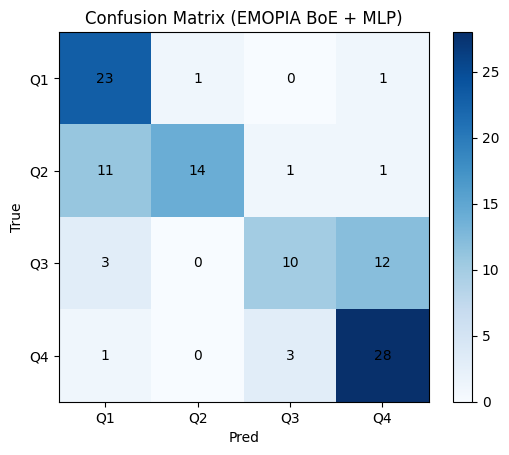

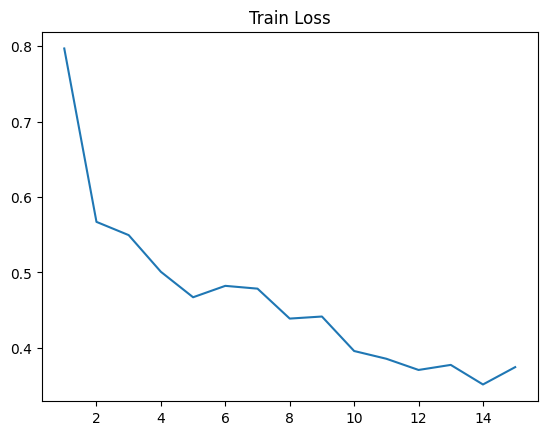

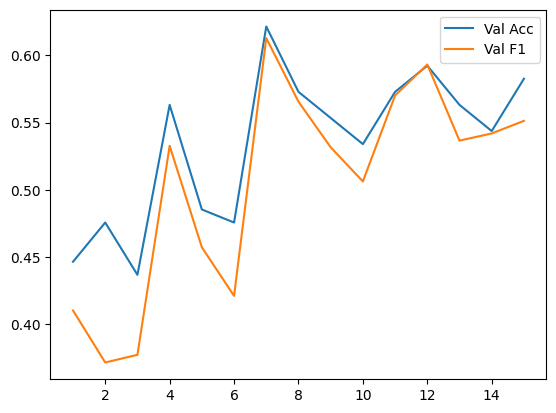

In [ ]:
#@title 测试集报告与混淆矩阵
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        logits = model(X)
        y_true += y.tolist()
        y_pred += logits.argmax(-1).cpu().tolist()

print(classification_report(y_true, y_pred, target_names=["Q1","Q2","Q3","Q4"]))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix (EMOPIA BoE + MLP)"); plt.colorbar()
plt.xticks(range(4),["Q1","Q2","Q3","Q4"]); plt.yticks(range(4),["Q1","Q2","Q3","Q4"])
for i in range(4):
    for j in range(4):
        plt.text(j,i,cm[i,j],ha='center',va='center',color='black')
plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

# 训练曲线
if hist:
    ep, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1 = zip(*hist)
    plt.plot(ep, tr_loss); plt.title("Train Loss"); plt.show()
    plt.plot(ep, va_acc, label="Val Acc"); plt.plot(ep, va_f1, label="Val F1"); plt.legend(); plt.show()


In [ ]:
#@title Segment-BoE：按时间分段的离散直方图特征（替换原 BoE）
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict

# —— 基本检查（要求 x / labels / seq_len 或 mask 已在环境中）——
assert 'x' in globals(), "未发现变量 x（应为 [N,T,C] 的离散事件张量）。"
assert 'labels' in globals(), "未发现 labels（长度为 N 的 Q1~Q4 列表）。"
assert ('seq_len' in globals()) or ('mask' in globals()), "需要 seq_len 或 mask 用于裁掉 padding。"

N, T, C = x.shape
LABEL2ID = {"Q1":0,"Q2":1,"Q3":2,"Q4":3}

def get_L(i:int) -> int:
    """返回第 i 条的有效长度 L。"""
    if 'seq_len' in globals() and seq_len is not None:
        return int(seq_len[i])
    m = mask[i]  # 1=有效, 0=pad
    return int(m.sum())

# —— 统计每通道的最大取值，决定每个通道的桶数（固定维度）——
max_bins = np.zeros(C, dtype=int)
for i in range(N):
    L = get_L(i)
    if L <= 0: continue
    vmax = x[i, :L].max(axis=0)      # 每通道最大取值
    max_bins = np.maximum(max_bins, vmax.astype(int))
max_bins = (max_bins + 1).tolist()   # 桶数 = 最大值 + 1（含0）
SEGMENTS = 4                          # 分段数 S，可改 3/4/6 试验
SEG_D = sum(max_bins) * SEGMENTS      # Segment-BoE 的最终维度
print(f"[Segment-BoE] 通道桶数: {max_bins} | 分段 S={SEGMENTS} | 特征维度 SEG_D={SEG_D}")

def seg_boe_single(x_i: np.ndarray, L: int, max_bins_by_ch, S: int) -> np.ndarray:
    """
    x_i: [T, C] 离散事件；只用前 L 步。
    将有效部分均分为 S 段（最后一段吸收余数），每段对每通道做定长直方图，拼接为 [1, S*Σ_bins]。
    """
    if L <= 0:
        return np.zeros((1, sum(max_bins_by_ch) * S), dtype=np.float32)
    # 计算每段的切分点
    # 例如 L=101, S=4 -> 边界 [0,25,50,75,101]
    base = L // S
    bounds = [0]
    for s in range(1, S):
        bounds.append(min(L, s*base))
    bounds.append(L)
    # 分段直方图
    feats = []
    for s in range(S):
        b0, b1 = bounds[s], bounds[s+1]
        xs = x_i[b0:b1] if b1>b0 else x_i[b0:b0+1]  # 防空段
        for ch in range(xs.shape[1]):
            v = xs[:, ch].astype(int)
            nb = int(max_bins_by_ch[ch])
            v = np.clip(v, 0, nb-1)
            hist = np.bincount(v, minlength=nb)[:nb].astype(np.float32)
            feats.append(hist)
    f = np.concatenate(feats).astype(np.float32)      # [S*Σ_bins]
    # 标准化（每样本一律 z-score）
    f = (f - f.mean())/(f.std() + 1e-6)
    return f[None, :]                                  # [1, SEG_D]

# —— 分层切分（若已有 tr_idx/va_idx/te_idx 会直接复用；否则新建 8/1/1）——
def stratified_indices(labels, ratios=(0.8,0.1,0.1), seed=2025):
    rng = np.random.default_rng(seed)
    by_lab = defaultdict(list)
    for i, lb in enumerate(labels):
        by_lab[lb].append(i)
    tr, va, te = [], [], []
    for lb, idxs in by_lab.items():
        rng.shuffle(idxs)
        n = len(idxs); n_tr = int(n*ratios[0]); n_va = int(n*ratios[1])
        tr += idxs[:n_tr]; va += idxs[n_tr:n_tr+n_va]; te += idxs[n_tr+n_va:]
    return tr, va, te

if not {'tr_idx','va_idx','te_idx'} <= set(globals().keys()):
    tr_idx, va_idx, te_idx = stratified_indices(labels)
print("分割大小:", len(tr_idx), len(va_idx), len(te_idx))

# —— Dataset / DataLoader ——
class EMOPIA_SegBoE(Dataset):
    def __init__(self, indices, S=SEGMENTS, max_bins_by_ch=max_bins):
        self.idxs = list(indices)
        self.S = S
        self.max_bins = max_bins_by_ch
    def __len__(self): return len(self.idxs)
    def __getitem__(self, k):
        i = self.idxs[k]
        L = get_L(i)
        f = seg_boe_single(x[i], L, self.max_bins, self.S)  # [1, SEG_D]
        y = LABEL2ID[labels[i]]
        return f.astype(np.float32), y

def collate_boe(batch):
    X = np.stack([b[0] for b in batch], 0)  # [B,1,SEG_D]
    y = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return torch.tensor(X), y

train_ds = EMOPIA_SegBoE(tr_idx)
val_ds   = EMOPIA_SegBoE(va_idx)
test_ds  = EMOPIA_SegBoE(te_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  collate_fn=collate_boe)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate_boe)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=collate_boe)

xb, yb = next(iter(train_loader))
print("Batch 形状:", xb.shape, yb.shape)  # 期望 [B,1,SEG_D], [B]

# —— 给出 in_feats，便于你重新初始化 MLP ——
print("请将模型的 in_feats 设置为:", xb.shape[-1], "(即 SEG_D)")


In [ ]:
#@title Logit 偏置校准：在验证集搜索 per-class bias，最大化 Macro-F1
import numpy as np, torch, torch.nn.functional as F
from sklearn.metrics import classification_report, f1_score, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def _predict_with_bias(model, loader, bias, device=DEVICE):
    """对 loader 推理，给每类加 bias（未过 softmax 的 logits 上加），返回 y_true, y_pred。"""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)                   # [B,4]
            logits = logits + torch.tensor(bias, device=device).float().view(1,-1)
            pred = logits.argmax(-1).cpu().tolist()
            y_true += y.tolist()
            y_pred += pred
    return np.array(y_true), np.array(y_pred)

def calibrate_bias_coord_descent(model, val_loader, rounds=3, grid=None):
    """
    坐标下降：轮流优化每一类的偏置，保留其它类不变；重复 rounds 轮。
    grid: 扫描的候选偏置（缺省为 -1.5~1.5 步长0.1）。
    返回 best_bias, best_f1。
    """
    if grid is None:
        grid = np.round(np.arange(-1.5, 1.5+1e-8, 0.1), 2)
    bias = np.zeros(4, dtype=float)
    best_f1 = -1.0
    # 初始分数
    yt, yp = _predict_with_bias(model, val_loader, bias)
    best_f1 = f1_score(yt, yp, average="macro")
    # 迭代
    for r in range(rounds):
        improved = False
        for c in range(4):
            best_c = bias[c]; best_c_f1 = best_f1
            for b in grid:
                cand = bias.copy(); cand[c] = b
                yt, yp = _predict_with_bias(model, val_loader, cand)
                f1 = f1_score(yt, yp, average="macro")
                if f1 > best_c_f1 + 1e-6:
                    best_c_f1 = f1; best_c = b
            if best_c != bias[c]:
                bias[c] = best_c; best_f1 = best_c_f1; improved = True
        if not improved:
            break
    return bias.tolist(), best_f1

def evaluate_with_bias(model, loader, bias=None, device=DEVICE, title=""):
    """带（或不带）偏置的评估与可视化（打印报告与混淆矩阵）。"""
    if bias is None:
        bias = [0,0,0,0]
    yt, yp = _predict_with_bias(model, loader, bias, device)
    print(title, "\nMacro-F1 =", f1_score(yt, yp, average="macro"))
    print(classification_report(yt, yp, target_names=["Q1","Q2","Q3","Q4"]))
    cm = confusion_matrix(yt, yp, labels=[0,1,2,3])
    try:
        import matplotlib.pyplot as plt
        plt.imshow(cm, cmap="Blues"); plt.title(f"Confusion Matrix {title}"); plt.colorbar()
        plt.xticks(range(4),["Q1","Q2","Q3","Q4"]); plt.yticks(range(4),["Q1","Q2","Q3","Q4"])
        for i in range(4):
            for j in range(4):
                plt.text(j,i,cm[i,j],ha='center',va='center',color='black')
        plt.xlabel("Pred"); plt.ylabel("True"); plt.show()
    except Exception:
        print("Confusion Matrix:\n", cm)

# —— 用法示例（假设你已训练好 model，并且有 val_loader / test_loader）——
# 1) 在验证集上搜索最优偏置
# best_bias, best_val_f1 = calibrate_bias_coord_descent(model, val_loader, rounds=3)
# print("Found bias:", best_bias, "| Val Macro-F1:", best_val_f1)

# 2) 验证集/测试集带偏置评估（与无偏置对比）
# evaluate_with_bias(model, val_loader,  bias=[0,0,0,0], title="[Val] No Bias")
# evaluate_with_bias(model, val_loader,  bias=best_bias,  title="[Val] With Bias")
# evaluate_with_bias(model, test_loader, bias=[0,0,0,0], title="[Test] No Bias")
# evaluate_with_bias(model, test_loader, bias=best_bias,  title="[Test] With Bias")
